# Head-restrained pipeline

**The following notebook illustrate the `HeadRestrainedPipeline` class.**
- **Several preprocessing steps are used for head-restrained recording of the tail angle**:
  - Preprocessing of the tail angle. In contrast with freely-swimming, more emphasis should be put on adjusting the baseline substraction.
  - Sparse coding of the tail angle.
  - Computation of the tail vigor associated to each atom of the sparse coding.


* Loading dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cycler import cycler

from megabouts.tracking_data import TrackingConfig, TailTrackingData, load_example_data
from megabouts.pipeline import HeadRestrainedPipeline

* Loading tracking data

In [2]:
df_recording, fps, mm_per_unit = load_example_data("HR_DLC")
df_recording = df_recording["DLC_resnet50_Zebrafish"]

tracking_cfg = TrackingConfig(fps=fps, tracking="tail_tracking")
kpts_list = [f"tail{i}" for i in range(11)]
thresh_score = 0.99
for kps in kpts_list:
    df_recording.loc[df_recording[(kps, "likelihood")] < thresh_score, (kps, "x")] = (
        np.nan
    )
    df_recording.loc[df_recording[(kps, "likelihood")] < thresh_score, (kps, "y")] = (
        np.nan
    )
tail_x = df_recording.loc[
    :,
    [
        (segment, "x")
        for segment, coord in df_recording.columns
        if segment in kpts_list and coord == "x"
    ],
].values
tail_y = df_recording.loc[
    :,
    [
        (segment, "y")
        for segment, coord in df_recording.columns
        if segment in kpts_list and coord == "y"
    ],
].values

tail_x = tail_x * mm_per_unit
tail_y = tail_y * mm_per_unit

tracking_data = TailTrackingData.from_keypoints(tail_x=tail_x, tail_y=tail_y)

* Defining the pipeline

In [3]:
pipeline = HeadRestrainedPipeline(tracking_cfg)

* In contrast with freely-swimming where the default baseline method is `"median"`, the default baseline method for head-restrained pipeline is set to `"whittaker"`.


In [4]:
pipeline.tail_preprocessing_cfg.baseline_method

'whittaker'

* Baseline Computation in Sparse Coding

Sparse coding is designed to capture high-frequency components in the signal. To handle low-frequency components effectively:

1. We first compute and subtract a baseline
2. The baseline smoothness is controlled by λ (lambda parameter):
   - **Higher λ values** → smoother baseline
   - **Lower λ values** → baseline follows signal more closely

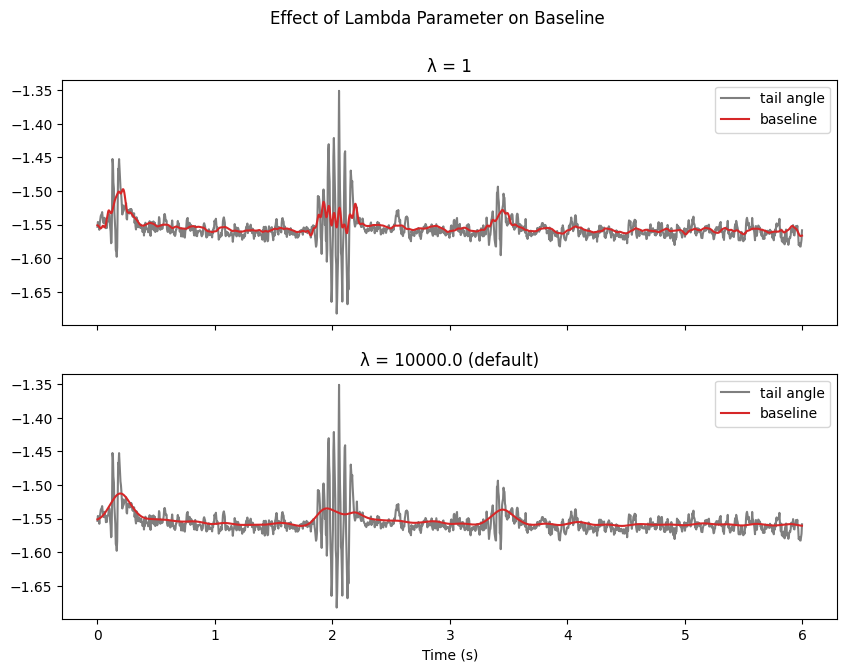

In [5]:
t = np.arange(tracking_data.T) / tracking_cfg.fps
IdSt = 20612
Duration = 1500
t_win = t[IdSt : IdSt + Duration] - t[IdSt]

fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
fig.suptitle("Effect of Lambda Parameter on Baseline")

for i, lmbda in enumerate([1, 1e4]):
    pipeline.tail_preprocessing_cfg.baseline_params["lmbda"] = lmbda
    tail = pipeline.preprocess_tail(tracking_data.tail_df)
    ax[i].plot(
        t_win, tail.angle[IdSt : IdSt + Duration, 7], "tab:gray", label="tail angle"
    )
    ax[i].plot(
        t_win,
        tail.angle_baseline[IdSt : IdSt + Duration, 7],
        "tab:red",
        label="baseline",
    )
    str_ = f"λ = {lmbda}"
    if lmbda == 1e4:
        str_ += " (default)"
    ax[i].set_title(str_)

    ax[i].legend()

ax[-1].set_xlabel("Time (s)")
plt.show()

* Once the baseline is computed, it is substracted from the tail angle.


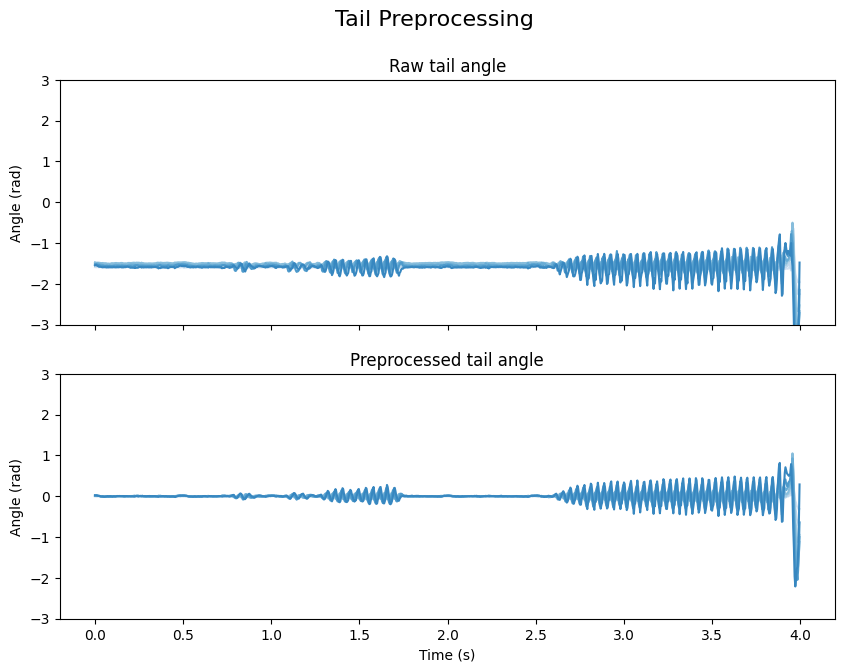

In [6]:
blue_cycler = cycler(color=plt.cm.Blues(np.linspace(0.2, 0.9, 10)))

t = np.arange(tracking_data.T) / tracking_cfg.fps
IdSt = 36000  # np.random.randint(tracking_data.T)
Duration = 1000
t_win = t[IdSt : IdSt + Duration] - t[IdSt]

# Prepare the data, titles, and subtitles
angle_data = [tail.angle, tail.angle_smooth]
subtitles = ["Raw tail angle", "Preprocessed tail angle"]

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

# Set a main title for the figure
fig.suptitle("Tail Preprocessing", fontsize=16)

# Loop over the axes, data, and subtitles
for axis, data, subtitle in zip(ax, angle_data, subtitles):
    axis.set_prop_cycle(blue_cycler)
    axis.plot(t_win, data[IdSt : IdSt + Duration, :7])
    axis.set(ylabel="Angle (rad)", ylim=(-3, 3))
    axis.set_title(subtitle, fontsize=12)

ax[-1].set_xlabel("Time (s)")
plt.show()

* Finally, sparse coding is applied to the preprocessed tail angle.


In [7]:
pipeline.sparse_coding_cfg

SparseCodingConfig(fps=250, lmbda=0.01, gamma=0.01, mu=0.05, window_inhib_ms=85, dict_peak_ms=28, vigor_win_ms=30)

* Here is the dictionary of atoms used for sparse coding:


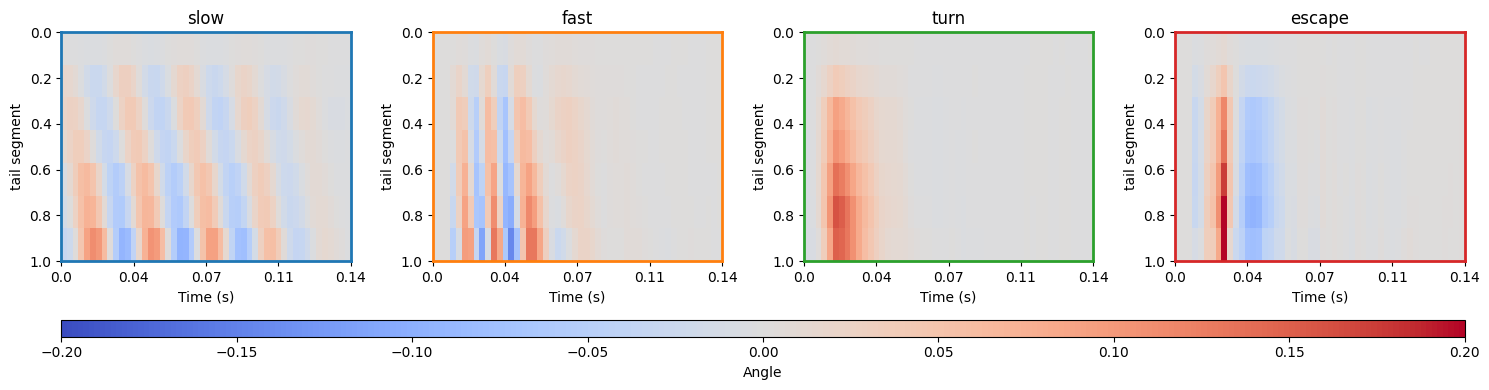

In [8]:
# Plot dictionary atoms
Dict = pipeline.sparse_coding_cfg.Dict

fig1 = plt.figure(figsize=(15, 4))
G = gridspec.GridSpec(2, 4, height_ratios=[4, 0.3])

atom_names = ["slow", "fast", "turn", "escape"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for i in range(Dict.shape[-1]):
    ax = plt.subplot(G[0, i])
    im = ax.imshow(
        Dict[:, :, i].T,
        aspect="auto",
        vmin=-0.2,
        vmax=0.2,
        cmap="coolwarm",
        extent=[0, 100, 1, 0],
    )
    ax.set_ylabel("tail segment")
    ax.set_xticks(np.linspace(0, 100, 5))
    ax.set_xticklabels(np.round(np.linspace(0, 100 / 700, 5), 2))

    for spine in ax.spines.values():
        spine.set_edgecolor(colors[i])
        spine.set_linewidth(2)
    ax.set_xlabel("Time (s)")
    ax.set_title(atom_names[i])

cbar_ax = plt.subplot(G[1, :])
cbar = plt.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Angle")
plt.tight_layout()
plt.show()

* Running the sparse coding:

In [9]:
sparse_coding_result = pipeline.compute_sparse_coding(tail.angle_smooth)

* We can now plot the results of the sparse coding. The color code of the atoms is the same as in the dictionary plot above.

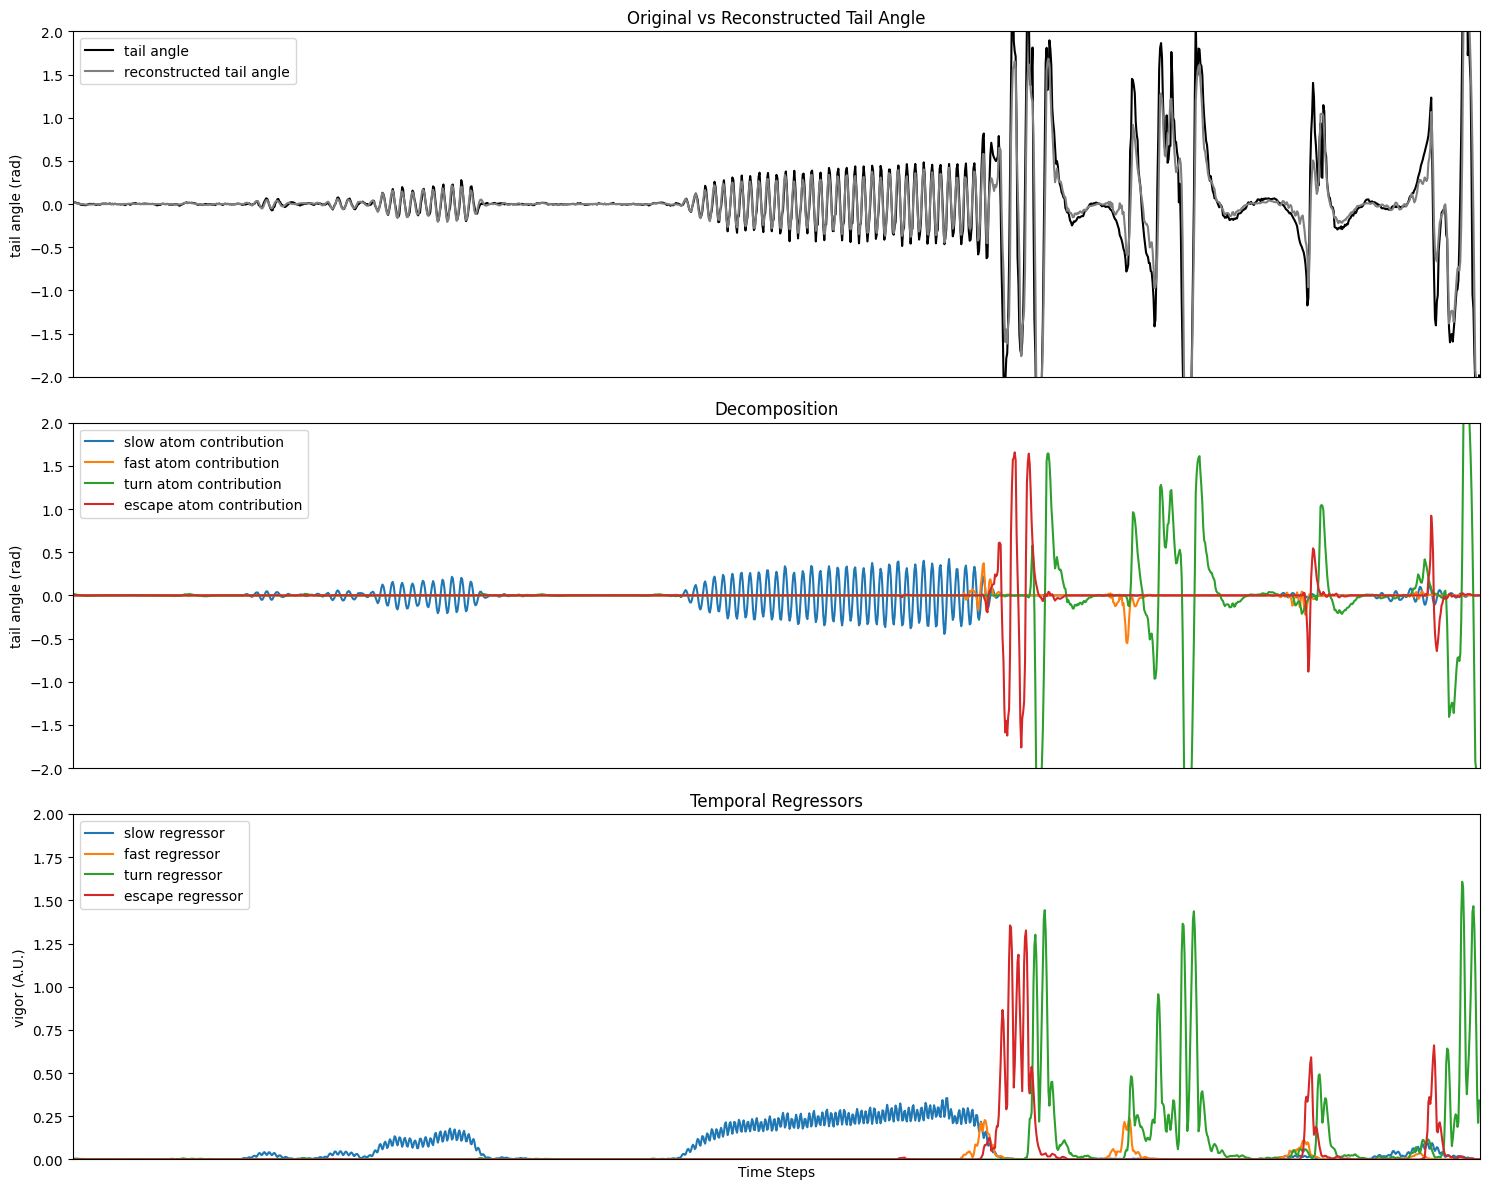

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

t = np.linspace(0, Duration / 700, Duration)
IdSt, Duration = 36000, 1500
IdEd = IdSt + Duration
lim_ampl = 2

ax1.plot(
    sparse_coding_result.tail_angle[IdSt : IdSt + Duration, 6],
    color="k",
    label="tail angle",
)
ax1.plot(
    sparse_coding_result.tail_angle_hat[IdSt : IdSt + Duration, 6],
    color="tab:gray",
    label="reconstructed tail angle",
)
ax1.set_ylim(-lim_ampl, lim_ampl)
ax1.get_xaxis().set_ticks([])
ax1.set_title("Original vs Reconstructed Tail Angle")
ax1.set_ylabel("tail angle (rad)")
ax1.legend()

ax2.plot(
    sparse_coding_result.decomposition[IdSt : IdSt + Duration, :],
    label=[f"{name} atom contribution" for name in atom_names],
)
ax2.set_ylim(-lim_ampl, lim_ampl)
ax2.get_xaxis().set_ticks([])
ax2.set_title("Decomposition")
ax2.set_ylabel("tail angle (rad)")
ax2.legend()

ax3.plot(
    sparse_coding_result.regressor[IdSt : IdSt + Duration, :],
    label=[f"{name} regressor" for name in atom_names],
)
ax3.set_ylim(0, 2)
ax3.set_xlim(0, Duration)
ax3.set_title("Temporal Regressors")
ax3.set_xlabel("Time Steps")
ax3.set_ylabel("vigor (A.U.)")
ax3.legend()

plt.tight_layout()
plt.show()